In [1]:
import scipy

In [2]:
from networkx.algorithms import bipartite
import networkx as nx
#random_graph(n, m, p[, seed, directed])
n = 20
m = 20
p = 0.6
seed = 1
directed = False
G = bipartite.random_graph(n, m, p, seed, directed)
reference_matching = nx.max_weight_matching(G, maxcardinality=True)
assert (len(reference_matching)==n)
import scipy.sparse as sps
# Convert the graph to a SciPy sparse matrix
mat = nx.to_scipy_sparse_array(G,format="lil")
#mat.setdiag(1)
print(mat.shape)

(40, 40)


In [3]:
from scipy.sparse import triu, tril
# Set diagonal to 1 so matrix is invertible
# Extract upper triangle of symmetric sparse matrix
upper_triangle = triu(mat,format="csc", k=1)
lower_triangle = tril(mat,format="csc")
mat=lower_triangle+(upper_triangle*-1)
print(mat.shape)

(40, 40)


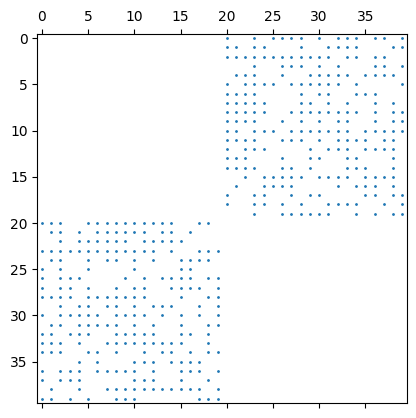

In [4]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.spy(mat, aspect='equal', marker='.', markersize=2)


In [5]:
from scipy import linalg
Aij = mat.copy().tocoo()
denseAdj = mat.copy().todense()
invMat = sps.linalg.inv(mat)
denseInv = invMat.copy().todense()
w = linalg.det(denseInv)
rows_removed = set()
cols_removed = set()
matchingGaussian = []
for i,j,v in zip(Aij.row, Aij.col, Aij.data):
    if i != j and i not in rows_removed and j not in cols_removed \
        and j not in rows_removed and i not in cols_removed:
            #print(i,j,v)
            denseS = denseAdj.copy()
            randomNumber = np.random.randint(1, 2*mat.shape[0], size=1)
            denseS[i,j]=randomNumber
            try:
                Bij = linalg.inv(denseS)
                det = linalg.det(Bij)
                if (Bij[j,i]!=0.0):
                    if (det==0.0):
                        print("Bad substitution!!!")
                    else:
                        rows_removed.add(i)
                        cols_removed.add(j)
                        rows_removed.add(j)
                        cols_removed.add(i)
                        denseAdj[i,j]=0.0
                        matchingGaussian.append((i,j))
            except Exception:
                continue
print(matchingGaussian)
assert(len(reference_matching)==len(matchingGaussian))

[(20, 0), (21, 1), (22, 2), (23, 3), (26, 4), (24, 5), (28, 6), (29, 7), (27, 8), (30, 9), (25, 10), (32, 11), (31, 12), (33, 13), (34, 14), (35, 15), (36, 16), (38, 17), (37, 18), (39, 19)]


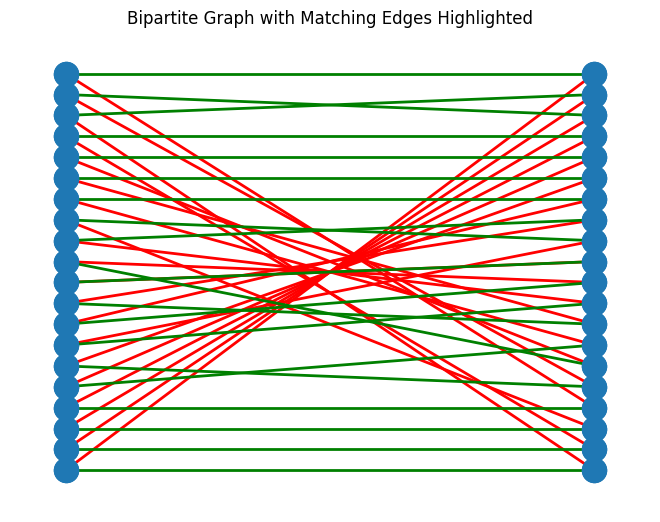

In [6]:
# Draw the graph with the perfect matching edges highlighted
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Get the nodes in each partition
partition1_nodes, partition2_nodes = bipartite.sets(G)
# Use bipartite_layout for bipartite graph visualization
pos = nx.bipartite_layout(G, partition1_nodes)

matching_graph = nx.Graph()
matching_graph.add_edges_from(reference_matching)

# Create a new graph with only the matching edges
#matching_gaussian_edges = [(u, v) for u, v in G.edges() if (u, v) in matching or (v, u) in matching]
matching_gaussian_edges = nx.Graph()
matching_gaussian_edges.add_edges_from(matchingGaussian)

# Draw the bipartite graph with matching edges highlighted in red
#nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=edge_colors, width=2.0)
nx.draw(matching_graph, pos, with_labels=False, edge_color='r', width=2.0)
nx.draw(matching_gaussian_edges, pos, with_labels=False, edge_color='g', width=2.0)

plt.title("Bipartite Graph with Matching Edges Highlighted")
plt.show()


In [7]:
import scipy.sparse as sps
from scipy.sparse import triu, tril
from scipy import linalg
def GaussMatching(G):
    # Convert the graph to a SciPy sparse matrix
    mat = nx.to_scipy_sparse_array(G,format="lil")
    #mat.setdiag(1)
    # Set diagonal to 1 so matrix is invertible
    # Extract upper triangle of symmetric sparse matrix
    upper_triangle = triu(mat,format="csc", k=1)
    lower_triangle = tril(mat,format="csc")
    mat=lower_triangle+(upper_triangle*-1)

    Aij = mat.copy().tocoo()
    denseAdj = mat.copy().todense()
    invMat = sps.linalg.inv(mat)
    denseInv = invMat.copy().todense()
    w = linalg.det(denseInv)
    rows_removed = set()
    cols_removed = set()
    matchingGaussian = []
    for i,j,v in zip(Aij.row, Aij.col, Aij.data):
        if i != j and i not in rows_removed and j not in cols_removed \
            and j not in rows_removed and i not in cols_removed:
                #print(i,j,v)
                denseS = denseAdj.copy()
                randomNumber = np.random.randint(1, 2*mat.shape[0], size=1)
                denseS[i,j]=randomNumber
                try:
                    Bij = linalg.inv(denseS)
                    det = linalg.det(Bij)
                    if (Bij[j,i]!=0.0):
                        if (det==0.0):
                            print("Bad substitution!!!")
                        else:
                            rows_removed.add(i)
                            cols_removed.add(j)
                            rows_removed.add(j)
                            cols_removed.add(i)
                            denseAdj[i,j]=0.0
                            matchingGaussian.append((i,j))
                except Exception:
                    continue
    return(matchingGaussian)

In [30]:
# Draw the graph with the perfect matching edges highlighted
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
def PlotMatching(G,Edmonds,Gauss):
    # Get the nodes in each partition
    partition1_nodes, partition2_nodes = bipartite.sets(G)
    # Use bipartite_layout for bipartite graph visualization
    pos = nx.bipartite_layout(G, partition1_nodes)

    matching_graph = nx.Graph()
    matching_graph.add_edges_from(Edmonds)

    # Create a new graph with only the matching edges
    #matching_gaussian_edges = [(u, v) for u, v in G.edges() if (u, v) in matching or (v, u) in matching]
    matching_gaussian_edges = nx.Graph()
    matching_gaussian_edges.add_edges_from(Gauss)

    # Draw the bipartite graph with matching edges highlighted in red
    #nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=edge_colors, width=2.0)
    # Draw the isolated nodes as well
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes)

    nx.draw(matching_graph, pos, with_labels=True, edge_color='r', width=2.0)

    plt.title("Bipartite Graph with Edmonds Edges Highlighted")
    plt.show()
    plt.title("Bipartite Graph with Gauss Edges Highlighted")
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes)
    nx.draw(matching_gaussian_edges, pos, with_labels=True, edge_color='g', width=2.0)
    plt.show()


Generated Bipartite Graph in 0.0001862049102783203 seconds
Generated reference matching in 0.0005896091461181641 seconds
Convert the graph to a SciPy sparse matrix in 0.0006115436553955078 seconds
{(19, 1), (7, 10), (18, 0), (11, 8), (16, 5), (13, 6), (15, 9), (3, 12), (14, 2), (17, 4)}
[(10, 0), (12, 1), (11, 2), (13, 3), (14, 4), (16, 5), (17, 6), (19, 7), (15, 9)]


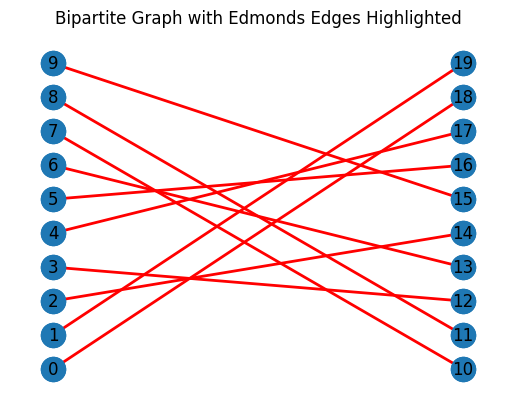

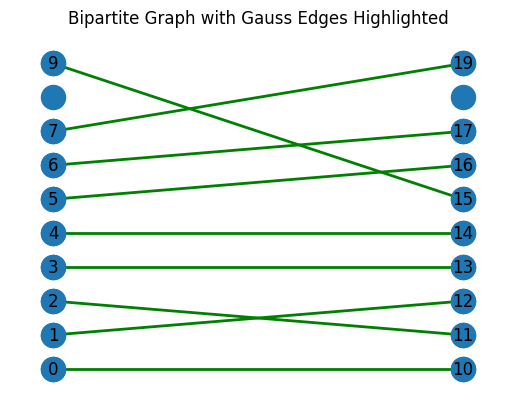

AssertionError: 

In [31]:
from networkx.algorithms import bipartite
import networkx as nx
import timeit
import time
# Wrap the code in a loop to increase n by powers of 10
for exponent in range(1, 4):  # Increase n by powers of 10 (1 to 4)
    n = 10 ** exponent
    m = n
    p = 0.6
    seed = 1
    directed = False
    
    # Generate a random graph
    # Record the start time
    start_time = time.time()
    G = nx.bipartite.random_graph(n, m, p, seed, directed)
    # Record the stop time
    stop_time = time.time()
    # Calculate the elapsed time
    elapsed_time = stop_time - start_time
    print(f"Generated Bipartite Graph in {elapsed_time} seconds")
    # Convert the graph to a SciPy sparse matrix
    start_time = time.time()
    
    start_time = time.time()
    Edmonds = nx.max_weight_matching(G, maxcardinality=True)
    # Record the stop time
    stop_time = time.time()
    # Calculate the elapsed time
    elapsed_time = stop_time - start_time
    print(f"Generated reference matching in {elapsed_time} seconds")
    start_time = time.time()
    assert (len(Edmonds)==n)

    mat = nx.to_scipy_sparse_array(G, format="csc")
    # Record the stop time
    stop_time = time.time()
    # Calculate the elapsed time
    elapsed_time = stop_time - start_time
    print(f"Convert the graph to a SciPy sparse matrix in {elapsed_time} seconds")
    # Wrap the gaussmatching method in a timeit function to get average time
    def time_Gauss():
        return GaussMatching(G)
    def time_Edmonds():
        return nx.max_weight_matching(G, maxcardinality=True)
    Gauss = GaussMatching(G)
    print(Edmonds)
    print(Gauss)
    PlotMatching(G,Edmonds,Gauss)
    assert(len(Gauss)==len(Edmonds))
    numSamples = 1
    execution_timeGauss = timeit.timeit(time_Gauss, number=numSamples) / numSamples  # 100 runs for averaging
    execution_timeEdmonds = timeit.timeit(time_Edmonds, number=numSamples) / numSamples  # 100 runs for averaging
    print(f"n={n}, Average Gauss Execution Time: {execution_timeGauss} seconds")
    #print(f"n={n}, Average GaussDOK Execution Time: {execution_timeGaussDOK} seconds")
    print(f"n={n}, Average Edmonds Execution Time: {execution_timeEdmonds} seconds")